In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_zip = '/content/drive/MyDrive/Mansoor_Share/Datasets/6476179.zip'
!unzip -o "$path_zip" -d "/content/"

Archive:  /content/drive/MyDrive/MansoorProposalWork/6476179.zip
 extracting: /content/swmh.tar.gz    


In [ ]:
!tar -xvzf /content/swmh.tar.gz -C /content/


swmh/
swmh/train.csv
swmh/test.csv
swmh/val.csv


In [ ]:
!pip install afinn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53431 sha256=0b2eddfb40d08061c182565d2a0cbd4b948cd40803619e5dfa1d6a187e602851
  Stored in directory: /root/.cache/pip/wheels/f9/72/27/74994e77200dae3d6aea2b546264500cee21f738c51241320b
Successfully built afinn


In [ ]:
!pip install -U transformers datasets accelerate evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
# ==============================
# ENVIRONMENT SETUP
# ==============================
!pip install transformers datasets evaluate accelerate shap

import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ==============================
# LOAD SWMH DATA
# ==============================
train_path = "/content/swmh/train.csv"
val_path   = "/content/swmh/val.csv"
test_path  = "/content/swmh/test.csv"


df_train = pd.read_csv(train_path)
df_val   = pd.read_csv(val_path)
df_test  = pd.read_csv(test_path)

# Basic checks
print(df_train['label'].value_counts())
print(df_val['label'].value_counts())
print(df_test['label'].value_counts())


Using device: cuda
label
self.depression      11940
self.SuicideWatch     6550
self.Anxiety          6136
self.offmychest       5265
self.bipolar          4932
Name: count, dtype: int64
label
self.depression      3032
self.SuicideWatch    1614
self.Anxiety         1508
self.offmychest      1332
self.bipolar         1220
Name: count, dtype: int64
label
self.depression      3774
self.SuicideWatch    2018
self.Anxiety         1911
self.offmychest      1687
self.bipolar         1493
Name: count, dtype: int64


In [ ]:


# ==============================
# TEXT CLEANING
# ==============================
import re

def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^A-Za-z0-9\s.,!?']", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

for df in [df_train, df_val, df_test]:
    df["text"] = df["text"].apply(clean_text)


# ==============================
# LABEL MAPPING
# ==============================
label2id = {l: i for i, l in enumerate(sorted(df_train['label'].unique()))}
id2label = {v: k for k, v in label2id.items()}

for df in [df_train, df_val, df_test]:
    df["label_id"] = df["label"].map(label2id)



In [ ]:
from afinn import Afinn
import numpy as np

af = Afinn()

def compute_emotion_score(text):
    text = text.lower()
    tokens = text.split()

    scores = []
    for tok in tokens:
        val = af.score(tok)
        if val < 0:               # only consider negative words
            # normalize from [-5,0] to [1,0]
            norm = abs(val) / 5.0
            scores.append(norm)

    if not scores:
        return 0.0   # positive or neutral text → intensity = 0

    return float(np.mean(scores))


In [ ]:

# ==============================
# APPLY EMOTION SCORE TO DATASETS
# ==============================
for df in [df_train, df_val, df_test]:
    df["emotion_score"] = df["text"].apply(compute_emotion_score)


# ==============================
# BUILD DATASETDICT
# ==============================
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train[["text", "label_id", "emotion_score"]]),
    "validation": Dataset.from_pandas(df_val[["text", "label_id", "emotion_score"]]),
    "test": Dataset.from_pandas(df_test[["text", "label_id", "emotion_score"]])
})


In [ ]:
# ==============================
# INSPECT SAMPLE SCORES
# ==============================

print("\n=== TRAIN SAMPLE ===")
for i in range(5):
    print(f"\nText: {df_train.iloc[i]['text']}")
    print(f"Label: {df_train.iloc[i]['label_id']}")
    print(f"Emotion Score: {df_train.iloc[i]['emotion_score']:.4f}")

print("\n=== VALIDATION SAMPLE ===")
for i in range(5):
    print(f"\nText: {df_val.iloc[i]['text']}")
    print(f"Label: {df_val.iloc[i]['label_id']}")
    print(f"Emotion Score: {df_val.iloc[i]['emotion_score']:.4f}")

print("\n=== TEST SAMPLE ===")
for i in range(5):
    print(f"\nText: {df_test.iloc[i]['text']}")
    print(f"Label: {df_test.iloc[i]['label_id']}")
    print(f"Emotion Score: {df_test.iloc[i]['emotion_score']:.4f}")



=== TRAIN SAMPLE ===

Text: wanting to skip or postpone my exam my exam is on saturday and i feel a massive urge to reschedule i experience this often with major exams. flashbacks to several years prior where i skipped all of my final exams and failed i just dont feel ready i dont know im so tired and mentallly fried that i feel a few days might help. but a part of me thinks i should fight this urge and just tank it
Label: 0
Emotion Score: 0.3000

Text: do other bipolar folks have problems with substance abuse? first i want say how great it is to be able to talk about things open in a way i never have before. i am at a good point in terms of drug and alcohol right now, but i've had big problems in the past. i od'd many times, each time it was not an intentional suicide attempt, it was me totally not caring about what happened to me and being in extreme distress, usually because of my abusive mother. all this occurred over the space of decades. once i fucked up bad with alcohol and met

In [ ]:
# ==============================
# TOKENIZATION (RoBERTa + emotion score)
# ==============================
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-large")

def tokenize_fn(batch):
    tok = tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=512
    )

    tok["labels"] = batch["label_id"]      # CE labels
    tok["emotion_score"] = batch["emotion_score"]  # regression labels

    return tok

tokenized = dataset.map(tokenize_fn, batched=True)

tokenized.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels", "emotion_score"]
)

print(tokenized)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/34823 [00:00<?, ? examples/s]

Map:   0%|          | 0/8706 [00:00<?, ? examples/s]

Map:   0%|          | 0/10883 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label_id', 'emotion_score', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 34823
    })
    validation: Dataset({
        features: ['text', 'label_id', 'emotion_score', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8706
    })
    test: Dataset({
        features: ['text', 'label_id', 'emotion_score', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10883
    })
})


In [ ]:
import numpy as np
import torch

# Count frequencies on train set
class_counts = df_train['label_id'].value_counts().sort_index().values
total = class_counts.sum()

# Inverse frequency weighting
class_weights = total / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Class weights:", class_weights)


Class weights: tensor([1.1350, 1.0633, 1.4121, 0.5833, 1.3228])


In [ ]:
def collate_fn(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.tensor([x["labels"] for x in batch]),
        "emotion_score": torch.tensor([x["emotion_score"] for x in batch])
    }


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel, AutoConfig

import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel, AutoConfig

class RobertaSWMHClassifier(nn.Module):
    def __init__(self, num_labels, class_weights, temperature=0.07):
        super().__init__()

        self.config = AutoConfig.from_pretrained(
            "roberta-large",
            num_labels=num_labels,
            output_hidden_states=False
        )

        self.encoder = AutoModel.from_pretrained("roberta-large", config=self.config)
        self.dropout = nn.Dropout(0.3)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.config.hidden_size, 128),
            nn.GELU(),
            nn.LayerNorm(128),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(128, num_labels)
        )

        # Regression head
        self.regressor = nn.Linear(self.config.hidden_size, 1)

        # Projection head for contrastive learning
        self.proj = nn.Sequential(
            nn.Linear(self.config.hidden_size, 128),
            nn.GELU(),
            nn.Linear(128, 64)
        )

        # class weights
        self.register_buffer("class_weights", class_weights)

        self.ce_loss = nn.CrossEntropyLoss(weight=self.class_weights)
        self.mse_loss = nn.MSELoss()
        self.temperature = temperature

    # --------------------------------------------------------
    # Supervised contrastive loss for CLS projection
    # --------------------------------------------------------
    def contrastive_loss(self, features, labels):
        features = F.normalize(features, dim=1)  # (B, D)
        sim = torch.matmul(features, features.T) / self.temperature  # (B, B)

        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float()
        mask.fill_diagonal_(0)  # remove self-pair

        exp_sim = torch.exp(sim)
        log_prob = sim - torch.log(exp_sim.sum(dim=1, keepdim=True))

        # only positives
        pos_log_prob = (mask * log_prob).sum(dim=1) / mask.sum(dim=1).clamp(min=1)

        return -pos_log_prob.mean()

    # --------------------------------------------------------
    # Forward pass
    # --------------------------------------------------------
    def forward(self, input_ids=None, attention_mask=None, labels=None, emotion_score=None):

        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS

        pooled = self.dropout(pooled)

        logits = self.classifier(pooled)
        emo_pred = self.regressor(pooled).squeeze(-1)

        # projection for contrastive loss
        proj_vec = self.proj(pooled)

        # -------------------------------------
        # TOTAL LOSS
        # -------------------------------------
        loss = None
        if labels is not None:

            ce = self.ce_loss(logits, labels.long())
            scl = self.contrastive_loss(proj_vec, labels.long())

            if emotion_score is not None:
                mse = self.mse_loss(emo_pred, emotion_score.float())
                loss = ce + 0.3 * mse + 0.1 * scl
            else:
                loss = ce + 0.1 * scl

        return {
            "loss": loss,
            "logits": logits,
            "emotion_pred": emo_pred,
            "proj_vec": proj_vec
        }


In [ ]:
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model = RobertaSWMHClassifier(
    num_labels=len(label2id),
    class_weights=class_weights_tensor
).to(device)


/tmp/ipython-input-3811427058.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# for name, param in model.named_parameters():
#     param.requires_grad = False

# for param in model.classifier.parameters():
#     param.requires_grad = True

# for n, p in model.named_parameters():
#     if p.requires_grad:
#         print("TRAINABLE:", n)
#     else:
#         print("FROZEN:", n)


In [ ]:
# ==============================
# METRICS
# ==============================
import numpy as np
import evaluate
def compute_metrics(eval_pred):
    preds_tuple, labels = eval_pred

    # preds_tuple is (logits, emo_pred)
    logits = preds_tuple[0]

    preds = np.argmax(logits, axis=-1)

    from sklearn.metrics import f1_score, accuracy_score

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro")
    }


In [ ]:
# ==============================
# TRAINING CONFIGURATION (fixed)
# ==============================
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

args = TrainingArguments(
    output_dir="./roberta_large_swmh_with_affine_emotion_constructive",
    eval_strategy="epoch",
    save_strategy="epoch",
    dataloader_num_workers=2,
    learning_rate=1e-6,              # Lower LR for deeper head
    weight_decay=0.05,               # Regularization
    warmup_ratio=0.1,                # Smooth LR ramp-up
    lr_scheduler_type="cosine",      # Gentle decay
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=15,
    load_best_model_at_end=True,     # Reload best checkpoint (lowest val loss)
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    label_smoothing_factor=0.1,
    fp16=True,
    logging_dir="./logs",
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)



In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.498600,1.027854,0.676775,0.681271
2,1.010100,0.945272,0.722375,0.727759
3,0.928900,0.928005,0.732598,0.742668
4,0.881800,0.913855,0.744199,0.753791
5,0.850100,0.933294,0.735470,0.744206


TrainOutput(global_step=21765, training_loss=1.0339035556476854, metrics={'train_runtime': 2553.3042, 'train_samples_per_second': 204.576, 'train_steps_per_second': 25.573, 'total_flos': 0.0, 'train_loss': 1.0339035556476854, 'epoch': 5.0})

In [ ]:
# ==============================
# MODEL EVALUATION
# ==============================
results = trainer.evaluate(tokenized["test"])
print(results)

# Save metrics
import json
with open("metrics.json", "w") as f:
    json.dump(results, f, indent=2)


{'eval_loss': 0.9296810626983643, 'eval_accuracy': 0.7394100891298355, 'eval_macro_f1': 0.7486332155911357, 'eval_runtime': 39.5199, 'eval_samples_per_second': 275.381, 'eval_steps_per_second': 34.438, 'epoch': 5.0}



Base evaluation metrics:
{
  "eval_loss": 0.9296810626983643,
  "eval_accuracy": 0.7394100891298355,
  "eval_macro_f1": 0.7486332155911357,
  "eval_runtime": 41.0845,
  "eval_samples_per_second": 264.893,
  "eval_steps_per_second": 33.127,
  "epoch": 5.0
}

Accuracy: 0.7394

Confusion Matrix:
[[1542   21   43  244   61]
 [  12 1492   15  436   63]
 [  70   41 1108  225   49]
 [ 127  549   64 2804  230]
 [  70  106   17  393 1101]]

Classification Report:
                   precision    recall  f1-score   support

     self.Anxiety       0.85      0.81      0.83      1911
self.SuicideWatch       0.68      0.74      0.71      2018
     self.bipolar       0.89      0.74      0.81      1493
  self.depression       0.68      0.74      0.71      3774
  self.offmychest       0.73      0.65      0.69      1687

         accuracy                           0.74     10883
        macro avg       0.77      0.74      0.75     10883
     weighted avg       0.75      0.74      0.74     10883



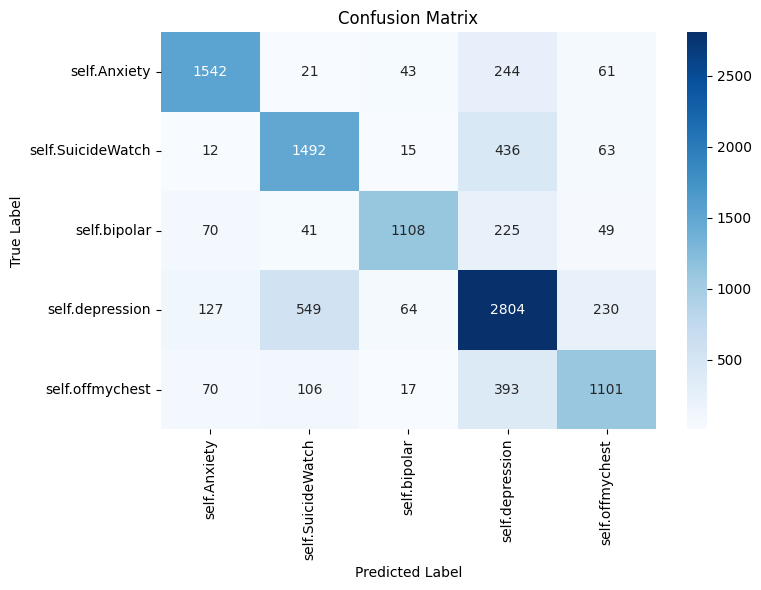

In [ ]:
# ==============================
# MODEL EVALUATION + PLOTS  (FIXED FOR MULTI-TASK MODEL)
# ==============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import json

# ------------------------------
# Evaluate model
# ------------------------------
results = trainer.evaluate(tokenized["test"])
print("\nBase evaluation metrics:")
print(json.dumps(results, indent=2))


# ------------------------------
# Predictions & Metrics
# ------------------------------
predictions = trainer.predict(tokenized["test"])

# predictions.predictions is a tuple because of multitask:
# (logits, emotion_pred)
logits = predictions.predictions[0]   # <-- FIX
y_pred = np.argmax(logits, axis=-1)
y_true = predictions.label_ids

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {acc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(label2id.keys())
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


# ------------------------------
# Plot Confusion Matrix
# ------------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)
plt.show()


# ------------------------------
# Save metrics
# ------------------------------
results["accuracy"] = float(acc)
results["confusion_matrix"] = cm.tolist()

with open("metrics.json", "w") as f:
    json.dump(results, f, indent=2)


In [ ]:
from sklearn.metrics import f1_score

overall_f1 = f1_score(y_true, y_pred, average="macro")
print(f"\nOverall Macro F1: {overall_f1:.4f}")
from sklearn.metrics import recall_score

overall_recall = recall_score(y_true, y_pred, average="macro")
print(f"\nOverall Macro Recall: {overall_recall:.4f}")
weighted_recall = recall_score(y_true, y_pred, average="weighted")
print(f"Weighted Recall: {weighted_recall:.4f}")




Overall Macro F1: 0.7486

Overall Macro Recall: 0.7368
Weighted Recall: 0.7394


In [ ]:
# # ==============================
# # SHAP EXPLAINABILITY (TOP 100 SAMPLES)
# # ==============================
# import shap
# subset = df_test.sample(100)
# texts = subset["text"].tolist()
# explainer = shap.Explainer(model, tokenizer)
# shap_values = explainer(texts)
# shap.plots.text(shap_values[0])


In [ ]:
best_checkpoint = trainer.state.best_model_checkpoint
best_checkpoint


'./roberta_large_swmh_with_affine_emotion_constructive/checkpoint-17412'

In [ ]:
!cp -r "$best_checkpoint" "/content/drive/MyDrive/MansoorProposalWork/SWMH_Training/best_checkpoint/"


In [ ]:
import torch

save_path = "/content/drive/MyDrive/MansoorProposalWork/SWMH_Training/"

torch.save(model.state_dict(), save_path + "/pytorch_modelroberta_emotion_wloss_constructive.bin")
tokenizer.save_pretrained(save_path)


('/content/drive/MyDrive/MansoorProposalWork/SWMH_Training/tokenizer_config.json',
 '/content/drive/MyDrive/MansoorProposalWork/SWMH_Training/special_tokens_map.json',
 '/content/drive/MyDrive/MansoorProposalWork/SWMH_Training/vocab.json',
 '/content/drive/MyDrive/MansoorProposalWork/SWMH_Training/merges.txt',
 '/content/drive/MyDrive/MansoorProposalWork/SWMH_Training/added_tokens.json',
 '/content/drive/MyDrive/MansoorProposalWork/SWMH_Training/tokenizer.json')